In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
from visualization import plot_cv_indices
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

ImportError: cannot import name 'plot_cv_indices' from 'visualization' (/Users/elroylo/anaconda3/lib/python3.11/site-packages/visualization/__init__.py)

In [5]:
# Load the labeled index data from csv
labeled_index = pd.read_csv("./data/labeled_data/quarterly_labeled_index_standardized.csv")

In [6]:
labeled_index.set_index(labeled_index['date'], inplace=True)
quarters = np.sort(labeled_index.index.unique())

## Build the model

In [7]:
# Call TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
evaluation = []

In [38]:
X_test_roc = []
Y_test_roc = []
for train_index, test_index in tscv.split(quarters):
    
    train_quarters, test_quarters = quarters[train_index], quarters[test_index]
    train = labeled_index.loc[train_quarters]
    test = labeled_index.loc[test_quarters]
    X_train = train[['price_change', 'volume_change', 'volatility']]
    y_train = train['crash_label']
    X_test = test[['price_change', 'volume_change', 'volatility']]
    y_test = test['crash_label']
    
    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Undersample the majority class (0) using RandomUnderSampler
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)

#     # Hyperparameter Tuning
#     param_grid = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'sag', 'saga']}
#     grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, verbose=2)
#     try:
#         grid_search.fit(X_train_scaled, y_train_resampled)
#         best_params = grid_search.best_params_
#         best_score = grid_search.best_score_
#         print(f"Best Score: {best_score}")
#         print("Grid search completed successfully.")
#     except Exception as e:
#         print("Error occurred during grid search:")
#         print(e)

    # Train the model
    model = LogisticRegression()
    #model = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
    model.fit(X_train_scaled, y_train_resampled)
    print("prediction model trained")
    
    # Evaluate the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    conf_matrix = confusion_matrix(y_test, y_pred, labels= [0,1])
    classification_rep = classification_report(y_test, y_pred)
    
    # Append result to evaluation_df
    evaluation.append((pd.to_datetime(train_quarters).min(),pd.to_datetime(train_quarters).max(),pd.to_datetime(test_quarters).min(),pd.to_datetime(test_quarters).max(),conf_matrix,classification_rep,accuracy,rmse,mape))
    # Concatenate X_test and y_test
    X_test_roc.append(X_test)
    Y_test_roc.append(y_test)

# Concatenate all X_test and y_test data
X_test_roc = pd.concat(X_test_roc)
Y_test_roc = pd.concat(Y_test_roc)

prediction model trained
prediction model trained
prediction model trained
prediction model trained
prediction model trained
            price_change  volume_change  volatility
date                                               
2005-03-31     -0.774340      -0.131833   -0.571108
2005-03-31     -0.307097      -0.131833   -0.305514
2005-03-31     -0.007624      -0.131833    0.701990
2005-03-31      0.441356      -0.131833   -0.602681
2005-03-31      0.014254      -0.131833   -0.612460
...                  ...            ...         ...
2019-12-31      0.455312      -0.131833   -0.264977
2019-12-31      0.603740      -0.131833   -0.575952
2019-12-31      0.633261      -0.131833    0.220976
2019-12-31      0.651821      -0.131833   -0.136525
2019-12-31      0.339044      -0.131833   -0.358316

[600 rows x 3 columns] date
2005-03-31    0
2005-03-31    0
2005-03-31    0
2005-03-31    0
2005-03-31    0
             ..
2019-12-31    0
2019-12-31    0
2019-12-31    0
2019-12-31    0
2019-12-31

/Users/elroylo/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/elroylo/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/elroylo/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/elroylo/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/Users/elroylo/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [10]:
evaluation_df = pd.DataFrame(evaluation, columns=['Train_Start', 'Train_End', 'Test_Start', 'Test_End',
                                       'Confusion_Matrix', 'Classification_Report', 'Accuracy', 'RMSE', 'MAPE'])
evaluation_df
#TODO: visualize it

,Train_Start,Train_End,Test_Start,Test_End,Confusion_Matrix,Classification_Report,Accuracy,RMSE,MAPE
0,2001-03-31,2004-12-31,2005-03-31,2007-12-31,"[[85, 31], [2, 2]]",precision recall f1-score ...,0.725000,0.524404,inf
1,2001-03-31,2007-12-31,2008-03-31,2010-12-31,"[[52, 38], [0, 30]]",precision recall f1-score ...,0.683333,0.562731,inf
2,2001-03-31,2010-12-31,2011-03-31,2013-12-31,"[[71, 41], [0, 8]]",precision recall f1-score ...,0.658333,0.584523,inf
3,2001-03-31,2013-12-31,2014-03-31,2016-12-31,"[[67, 42], [3, 8]]",precision recall f1-score ...,0.625000,0.612372,inf
4,2001-03-31,2016-12-31,2017-03-31,2019-12-31,"[[73, 46], [0, 1]]",precision recall f1-score ...,0.616667,0.619139,inf


# Feature Importance

['price_change', 'volume_change', 'volatility']
Feature: price_change, Importance: -2.4842342128835475
Feature: volume_change, Importance: 0.010965173777873687
Feature: volatility, Importance: 0.2564379543791611


/var/folders/wf/zmc25fvx2s982kwp_60tq45r0000gn/T/ipykernel_4802/82479688.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[feature] = X_train[feature].astype('float64')


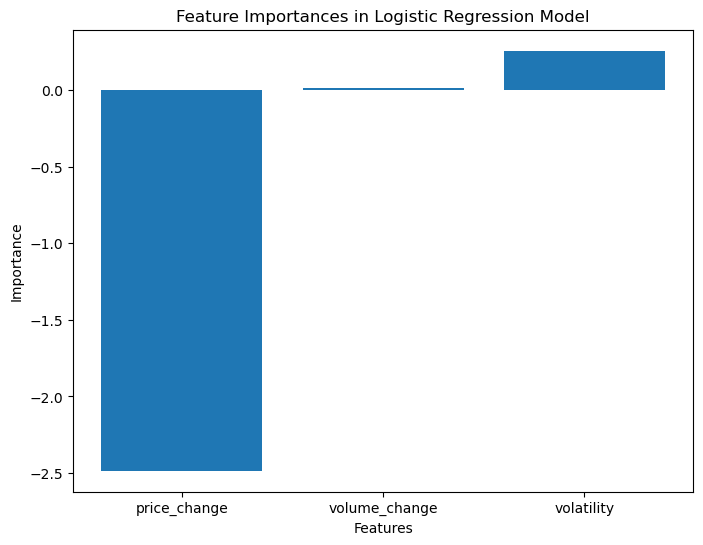

In [17]:
feature_names = list(X_train.columns)
print(feature_names)
# Determine non-numeric attribute names
for feature in feature_names:
    X_train[feature] = X_train[feature].astype('float64')
    
feature_importance = model.coef_[0]
for name, importance in zip(feature_names, feature_importance):
    print(f"Feature: {name}, Importance: {importance}")

plt.figure(figsize=(8, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importances in Logistic Regression Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

/Users/elroylo/anaconda3/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Crash Probability: 0.46337202900957003
AUC-ROC Score: 0.9118165784832452


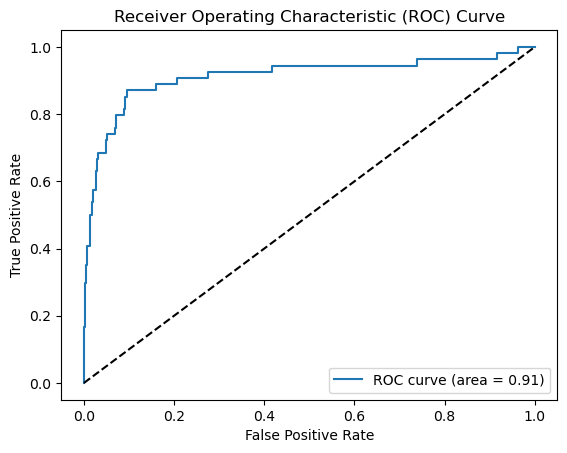

In [39]:
#Prediction Result
y_prob = model.predict_proba(X_test_roc)
crash_prob = y_prob[:, 1]
print(f"Crash Probability: {crash_prob.mean()}")

#AUC_ROC
auc_roc = roc_auc_score(Y_test_roc, y_prob[:, 1])
print("AUC-ROC Score:", auc_roc)

fpr, tpr, thresholds = roc_curve(Y_test_roc, y_prob[:, -1])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Expanding Window Validation
for i in range(1, len(labeled_index_by_date) + 1):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[:i], X.iloc[i-1:i]
    y_train, y_test = y.iloc[:i], y.iloc[i-1:i]

In [ ]:
# Define a function to create rolling windows of data
def create_rolling_windows(data, window_size, target_column):
    input_sequences = []
    labels = []
    for i in range(len(data) - window_size):
        input_sequences.append(data[i:i+window_size].drop(target_column, axis=1).values)
        labels.append(data.iloc[i+window_size][target_column])
    return np.array(input_sequences), np.array(labels)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Standardize the data
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Create rolling windows of training data
window_size = 4  # for example
X_train, y_train = create_rolling_windows(train_data, window_size, 'crash_label')

# Choose a machine learning model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Evaluate the model
X_test, y_test = create_rolling_windows(test_data, window_size, 'crash_label')
print("Model score: ", model.score(X_test, y_test))

# Use the model to predict future crashes
future_crash = model.predict(test_data[-window_size:].reshape(1, -1))
print("Predicted future crash: ", future_crash)

In [7]:
for month, labeled_index in labeled_index_dict.items():
    
    # Split the training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Undersample the majority class (0) using RandomUnderSampler
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)

    # Hyperparameter Tuning
    param_grid = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'sag', 'saga']}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, verbose=2)
    try:
        grid_search.fit(X_train_scaled, y_train_resampled)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    except Exception as e:
        print("Error occurred during grid search:")
        print(e)

    # Train the model
    model_dict[month] = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
    model_dict[month].fit(X_train_scaled, y_train_resampled)
    print(month, " prediction model trained")
    print()

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...................C=0.001, penalty=l1

[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.5s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.4s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.5s
[CV] END ...................

[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.5s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.4s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
Best Score: 0.5033099544727452
Grid search completed successfully.
1m  prediction model trained

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001,

[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.4s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.5s
[CV] END ...................

[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.5s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.1s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
Best Score: 0.5021866455295682
Grid search completed successfully.
3m  prediction model trained

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001,

[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.1s
[CV] END ...................

[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.2s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.2s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.2s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.3s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.2s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.3s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.1s
[CV] END ...................

## Model Evaluation 
- Precision: number of True Positives / (number of True Positives + number of False Positives)
- Recall: number of True Positives / (number of True Positives + number of False Negatives)
- F1 score: A weighted average of precision and recall, F1 = 2*((precision*recall)/(precision+recall))

In [13]:
# Evaluate the model
for month, model in model_dict.items():
    print(month, "prediction model:")
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"Accuracy: {accuracy}")
    print(f"RMSE: {rmse}")
    print(f'MAPE: {mape}%') 

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred, labels= [0,1]))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print()
    print()

1m prediction model:
Accuracy: 0.8553316621673737
RMSE: 0.38035291221788525
MAPE: inf%
Confusion Matrix:
[[17686  1352]
 [ 1649    57]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92     19038
         1.0       0.04      0.03      0.04      1706

    accuracy                           0.86     20744
   macro avg       0.48      0.48      0.48     20744
weighted avg       0.84      0.86      0.85     20744



3m prediction model:
Accuracy: 0.917421905129194
RMSE: 0.2873640458909326
MAPE: inf%
Confusion Matrix:
[[19031     7]
 [ 1706     0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     19038
         1.0       0.00      0.00      0.00      1706

    accuracy                           0.92     20744
   macro avg       0.46      0.50      0.48     20744
weighted avg       0.84      0.92      0.88     20744



6m prediction model:
Acc

Problem: low recall and f1 score for crash label 1

## Feature Importance

1m prediction model:
Feature: price_change, Importance: -10.229787344761199
Feature: volume_change, Importance: -26.347991834802144
Feature: volatility, Importance: -0.03195402811964382


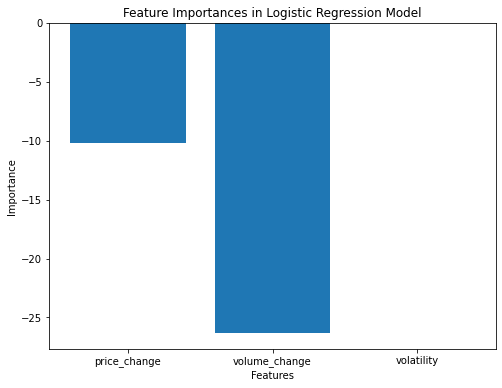

3m prediction model:
Feature: price_change, Importance: -0.021936308517597435
Feature: volume_change, Importance: -0.06247788899871693
Feature: volatility, Importance: -0.018565174206640486


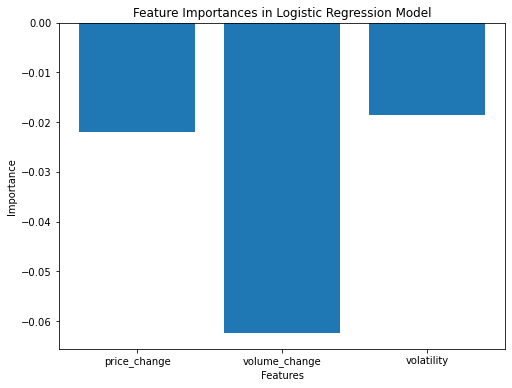

6m prediction model:
Feature: price_change, Importance: -0.00037621740443560754
Feature: volume_change, Importance: -0.04648673954590604
Feature: volatility, Importance: -0.04250126069458529


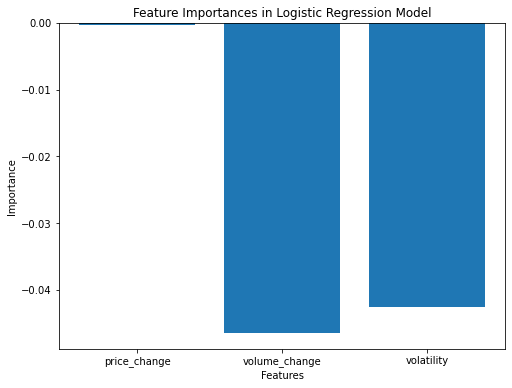

In [21]:
for month, model in model_dict.items():
    print(month, "prediction model:")
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        print(f"Feature: {name}, Importance: {importance}")

    plt.figure(figsize=(8, 6))
    plt.bar(feature_names, feature_importance)
    plt.title('Feature Importances in Logistic Regression Model')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

## Prediction Result & AUC-ROC

1m Crash Probability: 0.08942567696049515
1m AUC-ROC Score: 0.46052071213899715


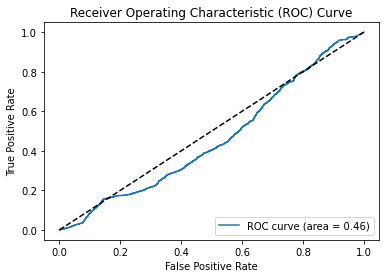

3m Crash Probability: 0.11029832897554202
3m AUC-ROC Score: 0.45485301994271465


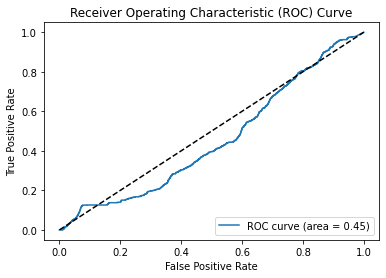

6m Crash Probability: 0.07837132285380859
6m AUC-ROC Score: 0.4548569609716212


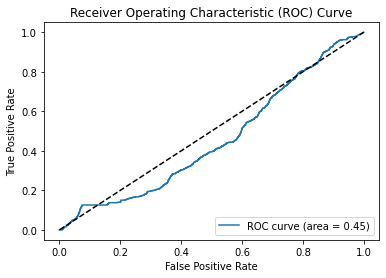

In [23]:
for month, model in model_dict.items():
    y_prob = model.predict_proba(X_test)
    crash_prob = y_prob[:, 1]
    print(f"{month} Crash Probability: {crash_prob.mean()}")
    auc_roc = roc_auc_score(y_test, y_prob[:, 1])

    print(f"{month} AUC-ROC Score: {auc_roc}")

    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, -1])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
!pip install visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.2/116.2 kB 2.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 858.3/858.3 kB 7.2 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 975.5 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.9/75.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 2.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 MB 15.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.7/690.7 kB 11.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.1/157.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.2/206.2 kB 6.5 MB/s eta